In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [6]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
tf.keras.backend.set_floatx('float32')
print("Ran the import statements.")

Ran the import statements.


In [9]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [10]:
train_df = train_df.sample(frac=1)
# or
# train_df = train_df.reindex(np.random.permutation(train_df.index))

## Normalize values
When creating a model with multiple features, the values of each feature should cover roughly the same range.<br>
The following code cell normalizes datasets by converting each raw value (including the label) to its Z-score

In [13]:
# Calculate the Z-scores of each column in the training set and write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
7680,0.6,-0.8,0.6,-0.1,-0.2,-0.3,-0.2,1.1,1.3
1770,1.2,-1.3,0.6,-0.4,-0.3,-0.6,-0.2,-0.5,0.7
12024,-0.9,0.6,-1.4,0.5,0.5,0.3,0.4,-0.4,0.0
2067,1.1,-0.9,-0.1,0.8,1.1,1.1,1.0,-1.0,-0.9
13709,-1.2,1.1,-2.0,-0.1,-0.3,-0.2,-0.2,1.1,-0.4


In [18]:
# Calculate the Z-scores of each column in the test set and write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

test_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.2,0.8,-0.1,0.6,0.3,0.1,0.3,1.5,1.2
1,0.6,-0.6,1.1,-0.5,-0.5,-0.6,-0.6,-0.1,-0.3
2,0.9,-0.9,-0.1,0.5,-0.1,0.1,0.0,1.1,0.6
3,0.6,-0.9,-0.1,-1.2,-1.2,-1.3,-1.3,1.3,1.1
4,-0.0,0.3,-0.8,-0.6,-0.7,-0.5,-0.7,-0.5,-1.1


## Task 1: Create a binary label
In classification problems, the label for every example must be either 0 or 1.<br>
If the median_house_value is higher than a certain arbitrary value (defined by threshold), then set median_house_value_is_high to 1. Otherwise, set median_house_value_is_high to 0.

In [26]:
threshold = 265000

In [29]:
train_df_norm['median_house_value_is_high'] = (train_df['median_house_value'] > threshold).astype(float)
test_df_norm['median_house_value_is_high'] = (test_df['median_house_value'] > threshold).astype(float)

In [30]:
test_df_norm['median_house_value_is_high'].head()

0   1.0
1   0.0
2   1.0
3   1.0
4   0.0
Name: median_house_value_is_high, dtype: float64

Alternatively, instead of picking the threshold based on raw house values, you can work with Z-scores. <br>
For example, the following possible solution uses a Z-score of +1.0 as the threshold, meaning that no more than 16% of the values in median_house_value_is_high will be labeled 1.

In [32]:
threshold_in_Z = 1.0

In [33]:
train_df_norm['median_house_value_is_high'] = (train_df_norm['median_house_value'] > threshold_in_Z).astype(float)
test_df_norm['median_house_value_is_high'] = (test_df_norm['median_house_value'] > threshold_in_Z).astype(float)

In [34]:
test_df_norm['median_house_value_is_high'].head()

0   1.0
1   0.0
2   0.0
3   1.0
4   0.0
Name: median_house_value_is_high, dtype: float64

## Represent features in feature columns

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. The transformations (collected in `feature_layer`) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.

In [36]:
# Create an empty list that will eventually hold all creasted feature columns
feature_columns = []

# Create a numerical feature column to represent median_income
median_income = tf.feature_column.numeric_column('median_income')
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms
total_rooms = tf.feature_column.numeric_column('total_rooms')
feature_columns.append(total_rooms)

# Convert the list of feature_columns into a layer that will later be fed into the model
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied to train_df_norm.
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[ 1.1183684 , -0.08287559],
       [-0.4680843 , -0.37324962],
       [-0.42794085,  0.4850281 ],
       ...,
       [-1.1443391 , -0.17874949],
       [-1.2345833 , -0.5425198 ],
       [ 2.120278  , -0.4723346 ]], dtype=float32)>

## Define functions that build and train a model

In [51]:
#@title Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
    
    # Add the feature layer (the list of features and how they are represented) to the model.
    model.add(feature_layer)
    
    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,), activation='sigmoid'))
    
#     model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
#                  metrics=([my_metrics]))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)
    
    return model

In [52]:
def train_model(model, dataset, epochs, label_name, batch_size=None, shuffle=True):
    # The x parameter of tf.keras.Model.fit can be a list of arrays, where each array contains 
    # the data for one feature.  Here, we're passing every column in the dataset.
    # Note that the feature_layer will filter away most of those columns, 
    # leaving only the desired columns and their representations as features.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(features, label, batch_size=batch_size, epochs=epochs, shuffle=shuffle)
    
    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
    
    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)
    
    return epochs, hist
    
print('Defined the create_model and train_model functions.')

Defined the create_model and train_model functions.


In [53]:
def plot_curve(epochs, hist, list_of_metrics):
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    
    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)
        
    plt.legend()
    
print('Defined the plot_curve function')

Defined the plot_curve function


## Invoke the creating, training, and plotting functions

The following code cell calls specify the hyperparameters, and then invokes the 
functions to create and train the model, and then to plot the results.

Epoch 1/20
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 3ms/step - loss: 0.7032 - accuracy: 0.5782
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6319 - accuracy: 0.6052
Epoch 3/20
170/170 [==============================] - 0s 3ms/step - loss: 0.5685 - accuracy: 0.6389
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5107 - accuracy: 0.6744
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4611 - accuracy: 0.7149
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4187 - accuracy: 0.7528
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3856 - accuracy: 0.7854
Epoch 8/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3601 - accuracy: 0.8170
Epoch 9/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3419 - accurac

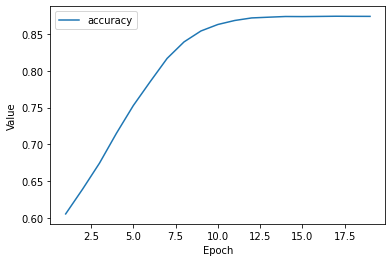

In [54]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy',
                                   threshold=classification_threshold)
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, label_name, batch_size)

# Plot a graph of the metrics vs.epoch
list_of_metrics_to_plot = ['accuracy']

plot_curve(epochs, hist, list_of_metrics_to_plot)

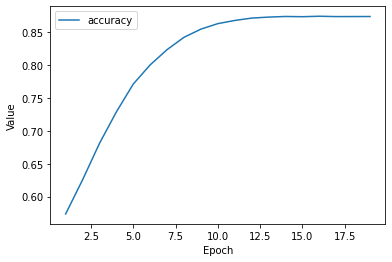

In [47]:
plot_curve(epochs, hist, list_of_metrics_to_plot)

## Evaluate the model against the test set

At the end of model training, you ended up with a certain accuracy against the *training set*. Invoke the following code cell to determine your model's accuracy against the *test set*.

In [55]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 3ms/step - loss: 0.3130 - accuracy: 0.8697


[0.3130052387714386, 0.8696666955947876]

## Task 2: How accurate is your model really?

Is your model valuable?

### a possible answer to Task 2.

A perfect model would make 100% accurate predictions.  Our model makes 80% accurate predictions. <br>
80% sounds good, but note that a model that always guesses "median_house_value_is_high is False" would be 75% accurate. 